# Initialization

In [28]:
#@title Mounting Gdrive

USE_G_COLAB = True #@param {type:"boolean"}

if USE_G_COLAB:
    from google.colab import drive

    
    drive.mount('/content/drive', force_remount=True)   

Mounted at /content/drive


In [0]:
#@title Project Root

root_dir = ''

if USE_G_COLAB:
    root_dir = '/content/drive/My Drive/Colab Notebooks/playground/mnist_persian/' #@param {type:"string"}

In [0]:
#@title Installing requried packages

!pip install -q tensorflow-gpu==2.0.0-beta1
!pip install -qU watermark

In [0]:
#@title Custom Matplotlib Style
mpl_style = "https://gist.githubusercontent.com/m3hrdadfi/af8aca01094afb7d3e5b46de9ad8d509/raw/871ec5d721a3b438c3c896718ea4aafc91ea9744/gadfly.mplstyle" #@param {type:"string"}

!wget -q $mpl_style -O /root/.config/matplotlib/matplotlibrc

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import pandas as pd

import cv2

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

import random
import sys
import io
import re
import time
import datetime
import os
import struct
from tqdm import tqdm

from unidecode import unidecode
from pprint import pprint


%matplotlib inline
mpl.rc_file(mpl.matplotlib_fname())

In [33]:
%reload_ext watermark
%watermark -m -n -p tensorflow,numpy,matplotlib,sklearn,cv2 -g

Sat Jul 06 2019 

tensorflow 2.0.0-beta1
numpy 1.16.4
matplotlib 3.0.3
sklearn 0.21.2
cv2 3.4.3

compiler   : GCC 8.0.1 20180414 (experimental) [trunk revision 259383
system     : Linux
release    : 4.14.79+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit
Git hash   :


# Preparing the dataset

In [0]:
#@title Dataset/Outputs directory

dataset_dir = 'dataset' #@param {type:"string"}
dataset_dir = os.path.join(root_dir, dataset_dir)

output_dir = 'outputs'  #@param {type:"string"}
output_dir = os.path.join(root_dir, output_dir)

os.makedirs(dataset_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

In [0]:
trainset_dir = 'DigitDB/Train 60000.cdb' #@param {type:"string"}
trainset_dir = os.path.join(dataset_dir, trainset_dir)

testset_dir = 'DigitDB/Test 20000.cdb' #@param {type:"string"}
testset_dir = os.path.join(dataset_dir, testset_dir)

In [0]:
def resize_image(src_image, dst_image_height, dst_image_width):
    src_image_height = src_image.shape[0]
    src_image_width = src_image.shape[1]

    if src_image_height > dst_image_height or src_image_width > dst_image_width:
        height_scale = dst_image_height / src_image_height
        width_scale = dst_image_width / src_image_width
        scale = min(height_scale, width_scale)
        img = cv2.resize(src=src_image, dsize=(0, 0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    else:
        img = src_image

    img_height = img.shape[0]
    img_width = img.shape[1]

    dst_image = np.zeros(shape=[dst_image_height, dst_image_width], dtype=np.uint8)

    y_offset = (dst_image_height - img_height) // 2
    x_offset = (dst_image_width - img_width) // 2

    dst_image[y_offset:y_offset + img_height, x_offset:x_offset + img_width] = img

    return dst_image


def read_cdb(filepath):
    with open(filepath, 'rb') as f:
        data = f.read()
        offset = 0

        # read private header
        yy = struct.unpack_from('H', data, offset)[0]
        offset += 2

        m = struct.unpack_from('B', data, offset)[0]
        offset += 1

        d = struct.unpack_from('B', data, offset)[0]
        offset += 1

        h = struct.unpack_from('B', data, offset)[0]
        offset += 1

        w = struct.unpack_from('B', data, offset)[0]
        offset += 1

        total_rec = struct.unpack_from('I', data, offset)[0]
        offset += 4

        letter_count = struct.unpack_from('128I', data, offset)
        offset += 128 * 4

        img_type = struct.unpack_from('B', data, offset)[0]  # 0: binary, 1: gray
        offset += 1

        comments = struct.unpack_from('256c', data, offset)
        offset += 256 * 1

        reserved = struct.unpack_from('245c', data, offset)
        offset += 245 * 1

        if (w > 0) and (h > 0):
            normal = True
        else:
            normal = False

        images = []
        labels = []

        for i in tqdm(range(total_rec), position=0):

            start_byte = struct.unpack_from('B', data, offset)[0]  # must be 0xff
            offset += 1

            label = struct.unpack_from('B', data, offset)[0]
            offset += 1

            if not normal:
                w = struct.unpack_from('B', data, offset)[0]
                offset += 1

                h = struct.unpack_from('B', data, offset)[0]
                offset += 1

            byte_count = struct.unpack_from('H', data, offset)[0]
            offset += 2

            image = np.zeros(shape=[h, w], dtype=np.uint8)

            if img_type == 0:
                # Binary
                for y in range(h):
                    b_white = True
                    counter = 0
                    while counter < w:
                        wb_count = struct.unpack_from('B', data, offset)[0]
                        offset += 1
                        
                        if b_white:
                            image[y, counter:counter + wb_count] = 0  # Background
                        else:
                            image[y, counter:counter + wb_count] = 255  # ForeGround
                        b_white = not b_white  # black white black white ...
                        counter += wb_count
            else:
                # GrayScale mode
                data = struct.unpack_from('{}B'.format(w * h), data, offset)
                offset += w * h
                image = np.asarray(data, dtype=np.uint8).reshape([w, h]).T

            images.append(image)
            labels.append(label)

        return images, labels
    

def load_data(datapath, img_height=32, img_width=32):
    images, labels = read_cdb(datapath)
    assert len(images) == len(labels)
    
    x = np.zeros(shape=[len(images), img_height, img_width], dtype=np.float32)
    y = np.zeros(shape=[len(labels)], dtype=np.int)
    
    for i in tqdm(range(len(images)), position=0):
        image = images[i]
        image = resize_image(src_image=image, dst_image_height=img_height, dst_image_width=img_width)
        image = image / 255
        image = np.where(image >= 0.5, 1, 0)
        
        x[i] = image
        y[i] = labels[i]
    
    x, y = shuffle(x, y, random_state=0)
    
    return x, y

In [37]:
x_train, y_train = load_data(trainset_dir)
x_test, y_test = load_data(testset_dir)

print('Train: %s, Labels: #%s' %(x_train.shape, len(y_train)))
print('Test: %s, Labels: #%s' %(x_test.shape, len(y_test)))

100%|██████████| 20000/20000 [00:00<00:00, 54318.65it/s]


Train: (60000, 32, 32), Labels: #60000
Test: (20000, 32, 32), Labels: #20000


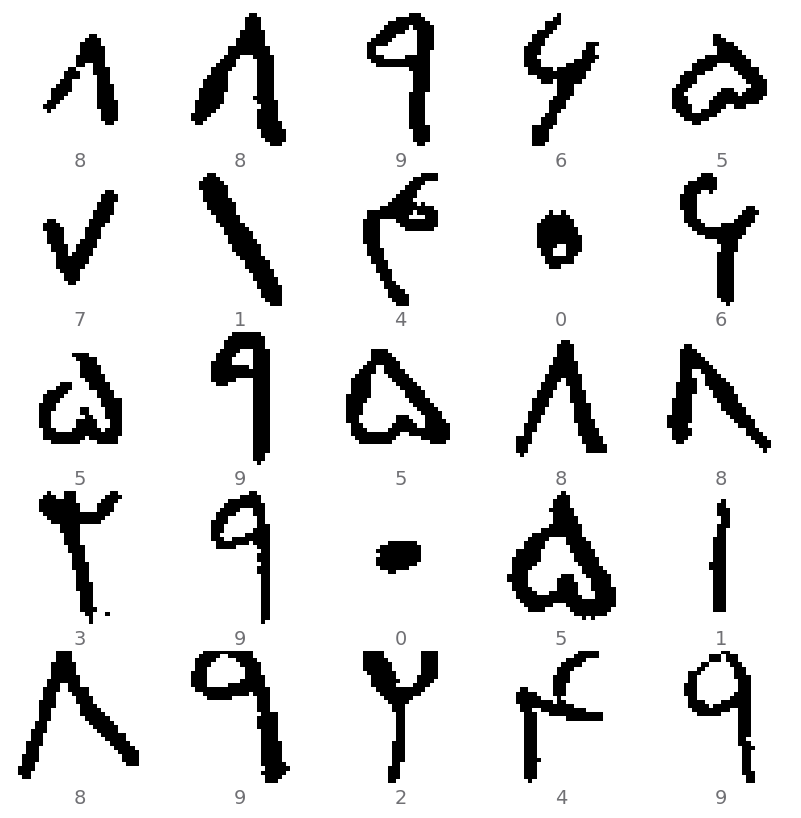

In [38]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(str(y_train[i]))
plt.show()

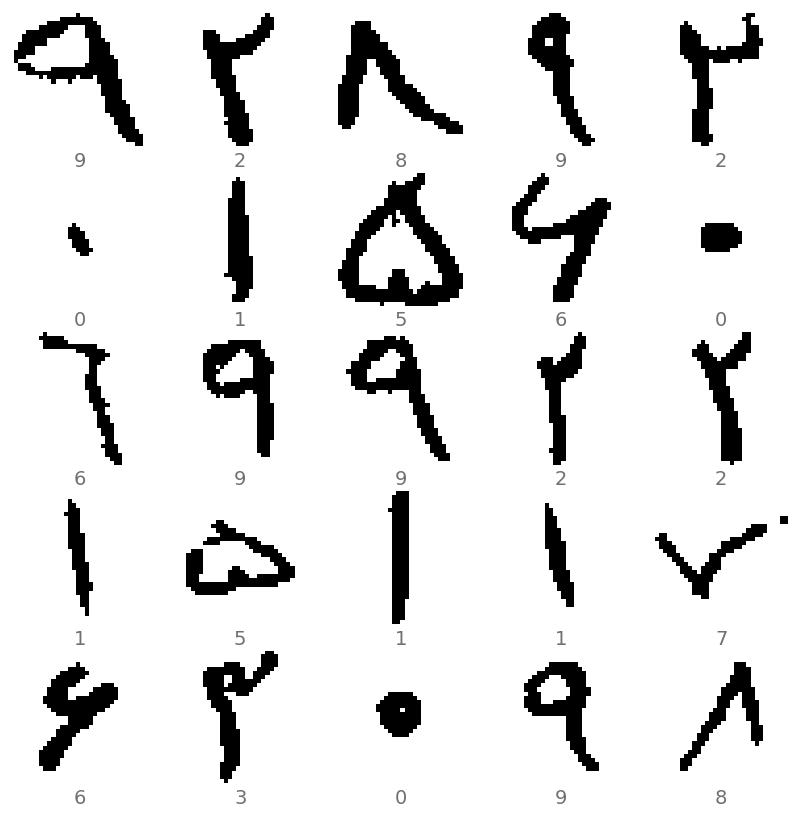

In [39]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel(str(y_test[i]))
plt.show()

# Preprocessing

In [40]:
# x_train = x_train / 255.0
# x_test = x_test / 255.0

dim_train = x_train.shape
x_train_ext = x_train.reshape((dim_train[0], dim_train[1], dim_train[2], 1))

dim_test = x_test.shape
x_test_ext = x_test.reshape((dim_test[0], dim_test[1], dim_test[2], 1))

print('Train: %s' % str(x_train_ext.shape))
print('Test: %s' % str(x_test_ext.shape))

Train: (60000, 32, 32, 1)
Test: (20000, 32, 32, 1)


# Arch

In [0]:
#@title Parameters Setup

# Size of the inputs and number of classes
X_SIZE, Y_SIZE, C_SIZE = x_train_ext.shape[1:]
D_CLASSES = list(set(y_train))
N_CLASSES = len(D_CLASSES)

# Epochs
DNN_UNITS = 64 #@param {type:"integer"}

# Epochs
EPOCHS = 10 #@param {type:"integer"}
VALIDATION_SPLIT = 0.1

In [0]:
def build_model(x_size, y_size, c_size, dnn_units, n_classes):
    
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(x_size, y_size, c_size)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(dnn_units, activation='relu'),
        tf.keras.layers.Dense(n_classes, activation='softmax')
    ])
    
    return model

In [43]:
model = build_model(X_SIZE, Y_SIZE, C_SIZE, DNN_UNITS, N_CLASSES)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [44]:
opt = tf.keras.optimizers.Adam()

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
r = model.fit(x_train_ext, y_train, epochs=EPOCHS, validation_split=VALIDATION_SPLIT, verbose=1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 7s 125us/sample - loss: 0.1038 - accuracy: 0.9675 - val_loss: 0.0371 - val_accuracy: 0.9887
Epoch 2/10
54000/54000 [==============================] - 6s 117us/sample - loss: 0.0279 - accuracy: 0.9914 - val_loss: 0.0155 - val_accuracy: 0.9943
Epoch 3/10
54000/54000 [==============================] - 6s 119us/sample - loss: 0.0181 - accuracy: 0.9945 - val_loss: 0.0172 - val_accuracy: 0.9943
Epoch 4/10
54000/54000 [==============================] - 6s 120us/sample - loss: 0.0128 - accuracy: 0.9958 - val_loss: 0.0136 - val_accuracy: 0.9955
Epoch 5/10
54000/54000 [==============================] - 6s 118us/sample - loss: 0.0102 - accuracy: 0.9966 - val_loss: 0.0125 - val_accuracy: 0.9963
Epoch 6/10
54000/54000 [==============================] - 6s 116us/sample - loss: 0.0086 - accuracy: 0.9972 - val_loss: 0.0160 - val_accuracy: 0.9945
Epoch 7/10
54000/54000 [===========================

In [48]:
history_dict = r.history
history_list = list(history_dict.keys())
print(history_list)

['loss', 'accuracy', 'val_loss', 'val_accuracy']


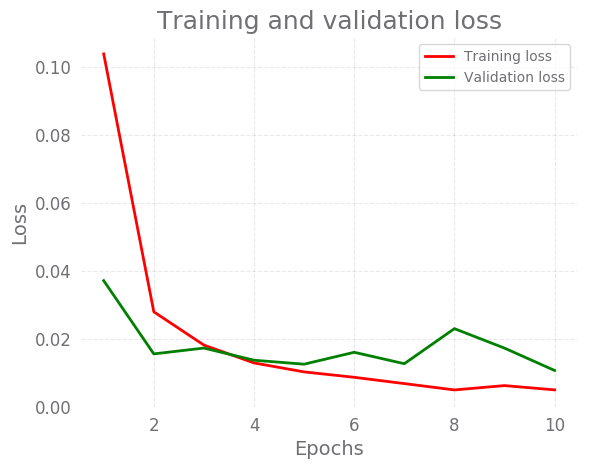

In [49]:
loss = history_dict[history_list[history_list.index('loss')]]
val_loss = history_dict[history_list[history_list.index('val_loss')]]

epochs = range(1, len(loss) + 1)

# plt.figure(figsize=(11.7, 8.27))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

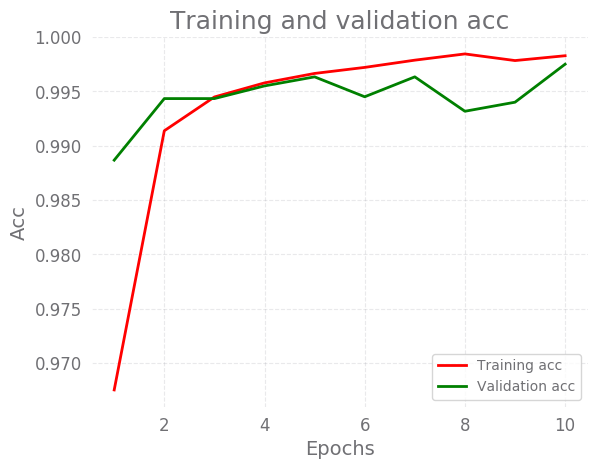

In [50]:
loss = history_dict[history_list[history_list.index('accuracy')]]
val_loss = history_dict[history_list[history_list.index('val_accuracy')]]

epochs = range(1, len(loss) + 1)

# plt.figure(figsize=(11.7, 8.27))
plt.plot(epochs, loss, 'r', label='Training acc')
plt.plot(epochs, val_loss, 'g', label='Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()

plt.show()

# Evaluating

In [0]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(str(predicted_label),
                                         100 * np.max(predictions_array),
                                         str(true_label)), color=color)


def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')


In [52]:
predictions = model.predict(x_test_ext)
print(predictions.shape)

(20000, 10)


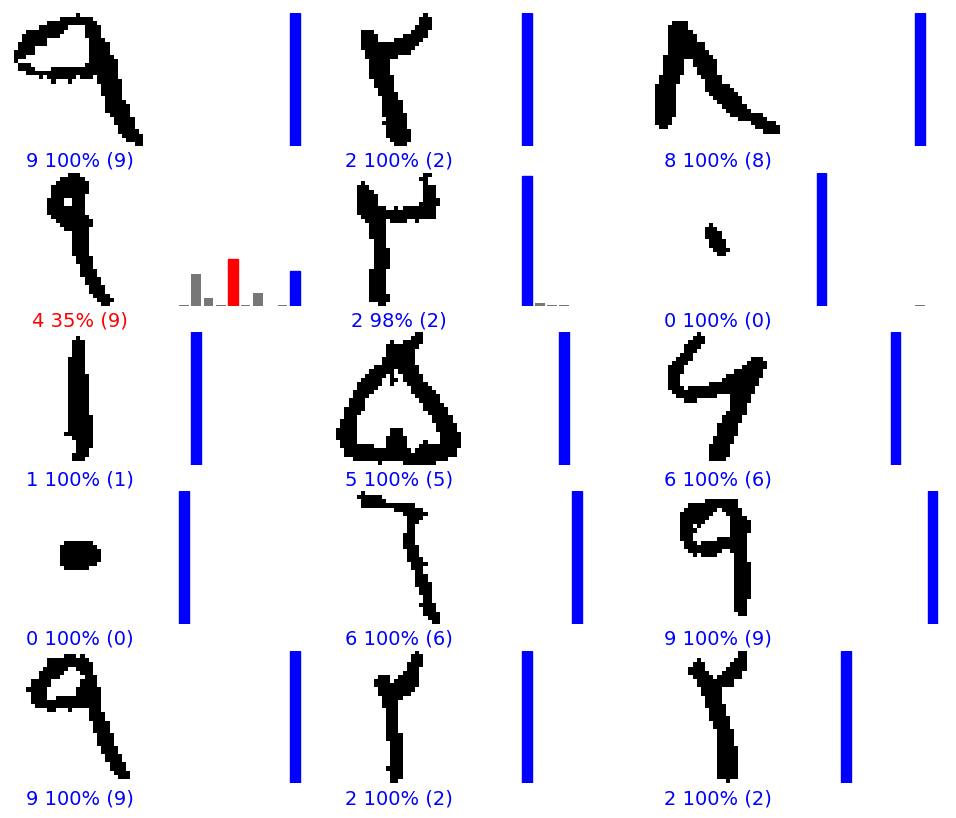

In [53]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.

num_rows = 5
num_cols = 3
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))

for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions, y_test, x_test)
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
    plot_value_array(i, predictions, y_test)
plt.show()
